In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys

from functions.data_loading import get_flight_persistence, get_condensed_distance_matrix
from functions.objects import PersistenceData

from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

sys.setrecursionlimit(10000)

Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\0010459cd263ebf1781aaab0d1e2c693.parquet created on 1740431523.3847969
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\001b035890f22537b7810d13c2394b52.parquet created on 1740429871.2724648
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\002b0d83bdd42cf4f943311e6c5405b9.parquet created on 1740423179.2816617
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\003fb04bed7e6d4017686073c719aebb.parquet created on 1740437766.6647403
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\004d6c782bd744c1cca3018e920ff100.parquet created on 1740425416.1031165
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\0068b289b241a49e5116ee0a66a27885.parquet created on 1740424442.9111085
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\007530806406ba42a4a47bf2bbea8241.parquet created on 1740434132.3575573
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\007efa2ee661d62efd6515f

In [2]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
trees, paths, file_name = get_flight_persistence(None, file_name, load_results=True)

distance_based_clusterings = {}
normal_clusterings = {}

In [3]:
pers_data = PersistenceData(trees, paths, "LL")

condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name)
distance_matrix = squareform(condensed_distance_matrix)

In [4]:
from functions.data_loading import get_condensed_distance_matrix

100%|██████████| 6948/6948 [00:33<00:00, 207.56it/s] 


In [5]:
Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

clustering = fcluster(Z, t=1.1, criterion='inconsistent', depth=2)

distance_based_clusterings["LINKAGE"] = clustering

In [6]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from collections import Counter

dbscan = DBSCAN(eps=0.00025, min_samples=3, metric="precomputed", n_jobs=10)
optics = OPTICS(metric="precomputed", n_jobs=10)

for cluster_method in [dbscan, optics]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(distance_matrix)
    distance_based_clusterings[method_name] = clustering

In [7]:
for key, clustering in distance_based_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Linkage:
1: 3 | 2: 7 | 3: 2 | 4: 2 | 5: 4 | 6: 3 | 7: 3 | 8: 2 | 9: 3 | 10: 6887 | 11: 14 | 12: 2 | 13: 2 | 14: 2 | 15: 3 | 16: 1 | 17: 8
Dbscan:
-1: 32 | 0: 6889 | 1: 10 | 2: 5 | 3: 6 | 4: 3 | 5: 3
Optics:
-1: 30 | 0: 6875 | 1: 10 | 2: 5 | 3: 11 | 4: 6 | 5: 11


AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

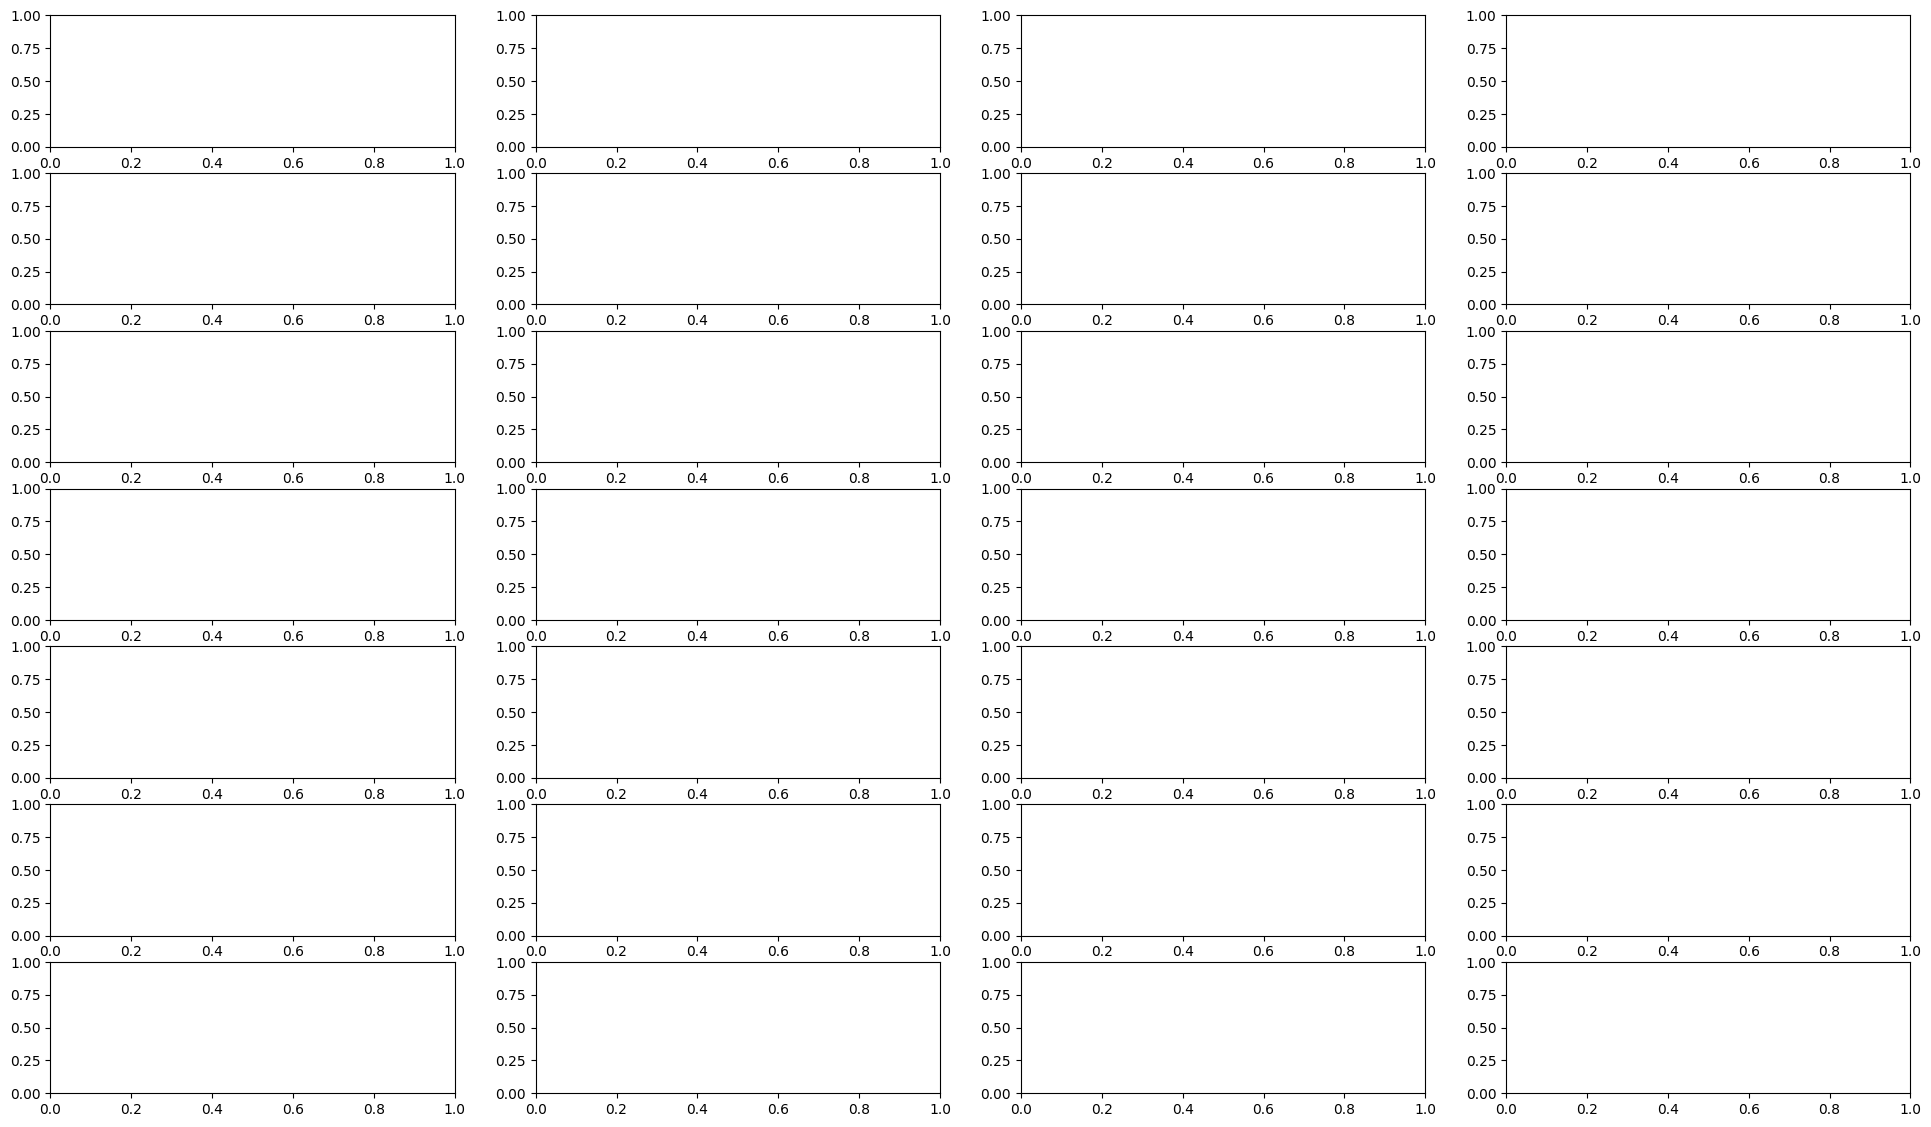

In [8]:
cluster_methods = ["LINKAGE", "DBSCAN", "OPTICS"]
sample_count = 4
method = cluster_methods[2]
method_name = cluster_method.__str__().split("(")[0]

clustering = distance_based_clusterings[method]
cluster_ids = np.unique(clustering)

fig, axs = plt.subplots(cluster_ids.shape[0], sample_count, figsize=(6 * sample_count, 2*cluster_ids.shape[0]))
if sample_count == 1:
    axs = np.expand_dims(axs, axis=1)

for i, cluster_id in enumerate(cluster_ids):
    cluster = np.where(clustering == cluster_id)[0]
    samples = np.random.choice(cluster, size=min(sample_count, len(cluster)), replace=False)
    
    for j, sample in enumerate(samples):
        scatter = pers_data.plot_raw_path(axs[i, j], sample, colour_bar=False)
        axs[i, j].set_title(None)
        if j > 0:
            axs[i, j].set_ylabel(None)
        if i < len(cluster_ids)-1:
            axs[i, j].set_xlabel(None)
fig.suptitle(f"Paths of {method_name} clusters", fontsize=20)
fig.subplots_adjust(top=0.95)

In [63]:
dbscan = DBSCAN(eps=0.0005, min_samples=2, n_jobs=6)
K_Means = KMeans(n_clusters=5)
optics = OPTICS(n_jobs=6)

data = pers_data.stats

normalizer = preprocessing.StandardScaler()
data = normalizer.fit_transform(data)

for cluster_method in [dbscan, optics, K_Means]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(data)
    normal_clusterings[method_name] = clustering

In [64]:
for key, clustering in normal_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Dbscan:
-1: 93 | 0: 6855
Optics:
-1: 75 | 0: 6859 | 1: 9 | 2: 5
Kmeans:
0: 6893 | 1: 5 | 2: 41 | 3: 1 | 4: 8


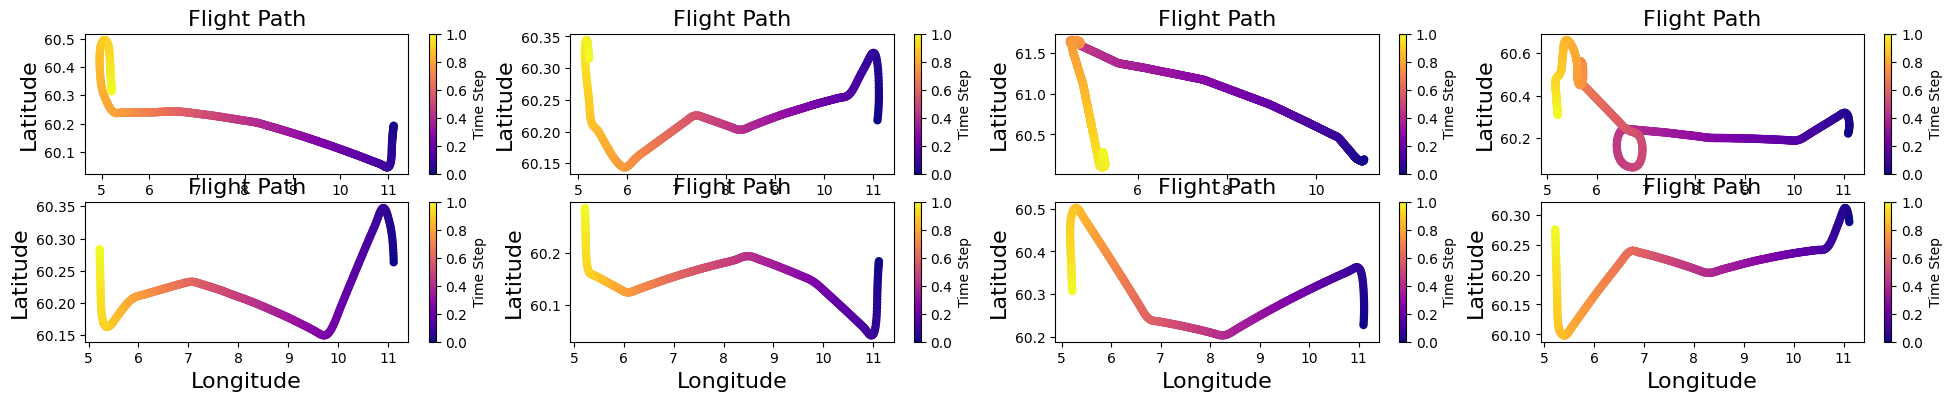

In [65]:
cluster_methods = ["DBSCAN", "OPTICS", "KMeans"]
sample_count = 4
method = cluster_methods[0]


clustering = normal_clusterings[method]
cluster_ids = np.unique(clustering)
fig, axs = plt.subplots(cluster_ids.shape[0], sample_count, figsize=(6 * sample_count, 2*cluster_ids.shape[0]))
for i, cluster_id in enumerate(cluster_ids):
    cluster = np.where(clustering == cluster_id)[0]
    samples = np.random.choice(cluster, size=min(sample_count, len(cluster)), replace=False)
    
    if sample_count == 1:
        pers_data.plot_raw_path(axs[i], samples[0])
    else:
        for j, sample in enumerate(samples):
            pers_data.plot_raw_path(axs[i, j], sample)